In [186]:
import numpy as np
import tinyarray
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse import eye
from scipy.sparse import kron
from scipy.sparse.linalg import inv
# from scipy.linalg import inv
from scipy.sparse import csr_matrix
import adaptive
from functools import partial
from scipy.interpolate import griddata


In [3]:
s0 = tinyarray.array([[1, 0], [0, 1]]);
sx = tinyarray.array([[0, 1], [1, 0]]);
sy = tinyarray.array([[0, -1j], [1j, 0]]);
sz = tinyarray.array([[1, 0], [0, -1]]);

In [162]:
def hdis(a,mu,delta,vz,alpha_R,dim,vimp):
    t=25/a**2
    alpha=alpha_R/(2*a)
    band11sm=spdiags(np.vstack([np.ones(dim),np.ones(dim)]),np.array([-1,1]),dim,dim,format = 'csr')
    band1m1sm=spdiags(np.vstack([np.ones(dim),-np.ones(dim)]),np.array([-1,1]),dim,dim,format = 'csr')
    eyesm=eye(dim)
    mulist=mu*np.ones(dim)-vimp
    diagmulist=spdiags(mulist,0,dim,dim)
    return kron(sz,(kron(eye(2),-t*band11sm+(2*t)*eyesm-diagmulist)+kron(sy,1j*alpha*band1m1sm)))\
    +kron(eye(2),kron(sz,vz*eyesm))+kron(sx,kron(eye(2),delta*eyesm))

In [163]:
hdis(1,1,0.2,0,5,2,0).toarray()

array([[ 49. +0.j, -25. +0.j,   0. +0.j,  -2.5+0.j,   0.2+0.j,   0. +0.j,
          0. +0.j,   0. +0.j],
       [-25. +0.j,  49. +0.j,   2.5+0.j,   0. +0.j,   0. +0.j,   0.2+0.j,
          0. +0.j,   0. +0.j],
       [  0. +0.j,   2.5+0.j,  49. +0.j, -25. +0.j,   0. +0.j,   0. +0.j,
          0.2+0.j,   0. +0.j],
       [ -2.5+0.j,   0. +0.j, -25. +0.j,  49. +0.j,   0. +0.j,   0. +0.j,
          0. +0.j,   0.2+0.j],
       [  0.2+0.j,   0. +0.j,   0. +0.j,   0. +0.j, -49. +0.j,  25. +0.j,
          0. +0.j,   2.5+0.j],
       [  0. +0.j,   0.2+0.j,   0. +0.j,   0. +0.j,  25. +0.j, -49. +0.j,
         -2.5+0.j,   0. +0.j],
       [  0. +0.j,   0. +0.j,   0.2+0.j,   0. +0.j,   0. +0.j,  -2.5+0.j,
        -49. +0.j,  25. +0.j],
       [  0. +0.j,   0. +0.j,   0. +0.j,   0.2+0.j,   2.5+0.j,   0. +0.j,
         25. +0.j, -49. +0.j]])

In [173]:
def ldosall_dis(a,mu,Delta,Vz,alpha_R,mulist,dim,omega,delta):
    ham=hdis(a,mu,Delta,Vz,alpha_R,dim,mulist);
    hh=csr_matrix((omega+1j*delta)*eye(4*dim)-ham)
    G=inv(hh)
    Gdiag=(G).diagonal()
    return -np.sum((np.reshape(Gdiag,(4,-1))),0).imag/np.pi

In [256]:
%%time
z=ldosall_dis(1,1,0.2,0,5,0,300,0,1e-3)

CPU times: user 688 ms, sys: 0 ns, total: 688 ms
Wall time: 700 ms


In [175]:
def LDOS_dis(p,a,mu,Delta,alpha_R,mulist,dim,delta):
    Vz,energy=p
    z=ldosall_dis(a,mu,Delta,Vz,alpha_R,mulist,dim,energy,delta)
    return np.array([z.mean(),z[0],z[int(dim/2)],z[-1]])

In [257]:
%%time
LDOS_dis((0,0),1,1,.2,5,0,300,1e-3)

CPU times: user 672 ms, sys: 15.6 ms, total: 688 ms
Wall time: 683 ms


array([5.66884378e-04, 5.53226965e-05, 5.67094080e-04, 5.53226965e-05])

In [251]:
learner = adaptive.Learner2D(partial(LDOS_dis,a=1,mu=1,Delta=0.2,alpha_R=5,mulist=0,dim=300,delta=1e-3),\
                             bounds=[(0., 2.), (-0.3, 0.3)])

In [252]:
%%time
running = adaptive.runner.simple(learner, goal=lambda l: l.loss() < 0.1)

CPU times: user 1min 36s, sys: 469 ms, total: 1min 36s
Wall time: 1min 38s


In [245]:
%%time
running = adaptive.BlockingRunner(learner, goal=lambda l: l.loss() < 0.1)

CPU times: user 2.31 s, sys: 1.89 s, total: 4.2 s
Wall time: 40.6 s


In [253]:
dd=np.array(list(learner.data.items()))
dz=dd[:,1]
dx=np.empty(dd.shape[0])
dy=np.empty(dd.shape[0])
for i in range(dd.shape[0]):
    dx[i],dy[i]=dd[i,0]
dz=np.vstack(dz)

/home/jake/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [254]:
dx.shape

(143,)

In [258]:
98/143

0.6853146853146853

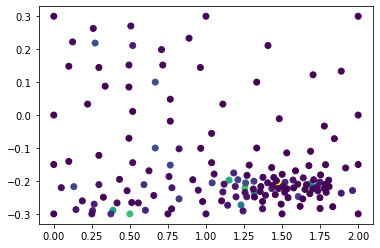

In [248]:
plt.scatter(dx,dy,c=dz[:,0])

In [249]:
dxx, dyy = np.meshgrid(np.linspace(0,2,100),np.linspace(-.3,.3,100))
dzz = griddata((dx,dy),dz[:,0],(dxx,dyy), method='linear')

/home/jake/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


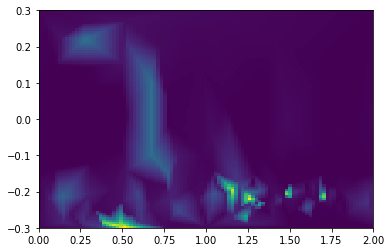

In [250]:
plt.pcolormesh(dxx,dyy,dzz)

In [294]:
z0=np.loadtxt('loss0.005m1.0D0.2muVar0.0L100_s.dat')

In [295]:
z0.shape

(29750, 6)

In [291]:
randlist=np.loadtxt('randlist.dat')

In [292]:
randlist.std()

0.2012568084812267

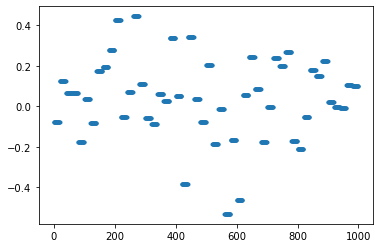

In [293]:
plt.plot(randlist,'.')

In [123]:
z0=ldosall_dis(1,1,0.2,0,5,0,3,0,1e-3)

In [127]:
z0,z1=ldosall_dis(1,1,0.2,0,5,0,3,0,1e-3)

In [133]:
z0

array([[-0.03171935-1.62112766e-06j, -0.04303087-2.82576914e-06j,
        -0.03171935-1.62112766e-06j],
       [-0.03171935-1.62112766e-06j, -0.04303087-2.82576914e-06j,
        -0.03171935-1.62112766e-06j],
       [ 0.03171935-1.62112766e-06j,  0.04303087-2.82576914e-06j,
         0.03171935-1.62112766e-06j],
       [ 0.03171935-1.62112766e-06j,  0.04303087-2.82576914e-06j,
         0.03171935-1.62112766e-06j]])

In [132]:
z1

array([[-0.03171935-1.62112766e-06j, -0.04303087-2.82576914e-06j,
        -0.03171935-1.62112766e-06j, -0.03171935-1.62112766e-06j],
       [-0.04303087-2.82576914e-06j, -0.03171935-1.62112766e-06j,
         0.03171935-1.62112766e-06j,  0.04303087-2.82576914e-06j],
       [ 0.03171935-1.62112766e-06j,  0.03171935-1.62112766e-06j,
         0.04303087-2.82576914e-06j,  0.03171935-1.62112766e-06j]])

In [6]:
    return kron(sz,(kron(eye(2),-t*band11sm+(2*t)*eyesm-diagmulist)+kron(sy,1j*alpha*band1m1sm)))\
    +kron(eye(2),kron(sz,vz*eyesm))+kron(sx,kron(eye(2),delta*eyesm))

25.0

In [15]:
np.vstack([np.ones(10),np.ones(10)])

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [26]:
eye(4)

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements (1 diagonals) in DIAgonal format>

In [28]:
np.ones(2).T

array([1., 1.])

In [35]:
eye(2)

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements (1 diagonals) in DIAgonal format>

In [70]:
kron(eye(2),np.ones((4,4)))

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements (blocksize = 4x4) in Block Sparse Row format>

In [61]:
np.ones((10,10))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])